# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW04] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом задании вам предстоит реализовать классический перцептрон, немного улчшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [30]:
import numpy as np
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from typing import NoReturn

In [31]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        #print(pts)
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")

    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [32]:
class Perceptron:
    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """
        self.iterations = iterations
        self.w = None
        self.unique_classes = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает простой перцептрон. 
        Для этого сначала инициализирует веса перцептрона,
        а затем обновляет их в течении iterations итераций.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        self.w = np.ones(X.shape[1]+1)
        X_new = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X.copy()))

        self.unique_classes = np.unique(y)

        y_true = y.copy()
        y_true[y == self.unique_classes[0]] = -1
        y_true[y == self.unique_classes[1]] = 1

        for _ in range(self.iterations):
            h = np.sign(X_new @ self.w)
            ind = h != y_true
            if np.any(ind):
                # self.w += np.sum((X_new[ind] * y_true[ind].reshape(-1, 1)), axis=0)
                self.w += X_new[ind][0] * y_true[ind][0]
            
    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        X_new = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X.copy()))
        y_pred = np.sign(X_new @ self.w)

        m_ones = y_pred == -1
        ones = y_pred == 1
        y_pred[m_ones] = self.unique_classes[0]
        y_pred[ones] = self.unique_classes[1]
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

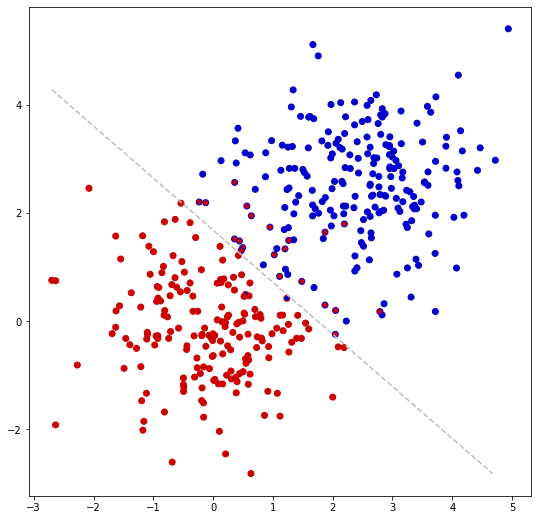

In [33]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

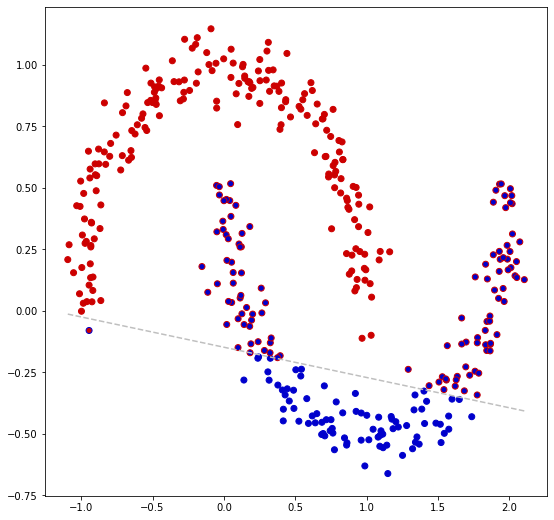

In [34]:
X, true_labels = make_moons(400, noise=0.075)
c = Perceptron()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [35]:
from sklearn.metrics import accuracy_score

class PerceptronBest:

    def __init__(self, iterations: int = 100):
        """
        Parameters
        ----------
        iterations : int
        Количество итераций обучения перцептрона.

        Attributes
        ----------
        w : np.ndarray
        Веса перцептрона размерности X.shape[1] + 1 (X --- данные для обучения), 
        w[0] должен соответстовать константе, 
        w[1:] - коэффициентам компонент элемента X.

        Notes
        -----
        Вы можете добавлять свои поля в класс.
        
        """
        self.iterations = iterations
        self.w = None
        self.unique_classes = None



    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Обучает перцептрон.

        Для этого сначала инициализирует веса перцептрона, 
        а затем обновляет их в течении iterations итераций.

        При этом в конце обучения оставляет веса, 
        при которых значение accuracy было наибольшим.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, на котором обучается перцептрон.
        y: np.ndarray
            Набор меток классов для данных.
        
        """
        self.w = np.zeros(X.shape[1]+1)
        X_new = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X.copy()))

        w_cur = np.zeros(X.shape[1]+1)
        cur_score = 0
        scores = []
        weights = []

        self.unique_classes = np.unique(y)

        y_true = y.copy()
        y_true[y_true == self.unique_classes[0]] = -1
        y_true[y_true == self.unique_classes[1]] = 1

        for _ in range(self.iterations):
            h = np.sign(X_new @ w_cur)
            ind = h != y_true
            if np.any(ind):
                # w_cur += np.sum((X_new[ind] * y_true[ind].reshape(-1, 1)), axis=0)
                w_cur += X_new[ind][0] * y_true[ind][0]
            cur_score = accuracy_score(y_true, h)
            scores.append(cur_score)
            weights.append(w_cur)
        self.w = w_cur
        self.w = weights[np.argmax(scores)]


    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Предсказывает метки классов.
        
        Parameters
        ----------
        X : np.ndarray
            Набор данных, для которого необходимо вернуть метки классов.
        
        Return
        ------
        labels : np.ndarray
            Вектор индексов классов 
            (по одной метке для каждого элемента из X).
        
        """
        X_new = np.hstack((np.ones(X.shape[0]).reshape(-1, 1), X.copy()))
        y_pred = np.sign(X_new @ self.w)

        m_ones = y_pred == -1
        ones = y_pred == 1
        y_pred[m_ones] = self.unique_classes[0]
        y_pred[ones] = self.unique_classes[1]
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

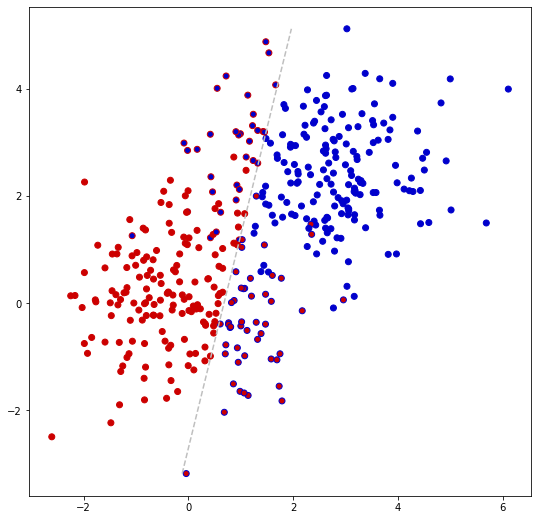

In [36]:
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

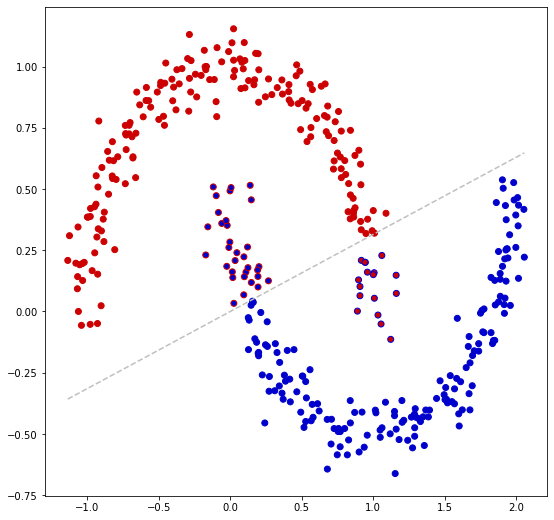

In [37]:
X, true_labels = make_moons(400, noise=0.075)
c = PerceptronBest()
c.fit(X, true_labels)
visualize(X, true_labels, np.array(c.predict(X)), c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [38]:
def transform_images(images: np.ndarray) -> np.ndarray:
    """
    Переводит каждое изображение в вектор из двух элементов.
        
    Parameters
    ----------
    images : np.ndarray
        Трехмерная матрица с черное-белыми изображениями.
        Её размерность: (n_images, image_height, image_width).

    Return
    ------
    np.ndarray
        Двумерная матрица с преобразованными изображениями.
        Её размерность: (n_images, 2).
    """
    features = np.zeros((images.shape[0], 2))
    features[:, 0] = np.mean(images, axis=(1, 2))    # интенсивность
    features[:, 1] = np.mean(np.abs(images-images[:, ::-1, :]), axis=(1, 2))    # симметричность в вектикальном направлении. Хвостик и шапочка у пятерки не очень симметричные
    return features


def get_digits(y0 = 1, y1 = 5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Оценка за это задание выставляется следующим образом:
1. 1 балл - что-то обучается, картинки рисуются
2. 2 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 80%
3. 4 балла - точность хотя бы одного из классификаторов на тестовой выборке больше 90%

__Обратите внимание, что перцептрон детерминирован, а выборка должна разбиваться без перемешивания__

In [39]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)

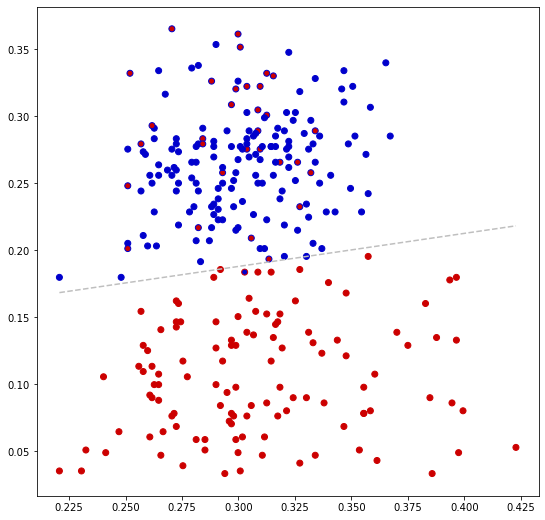

Accuracy: 0.9726027397260274
CPU times: user 4.15 s, sys: 16 ms, total: 4.17 s
Wall time: 4.17 s


In [40]:
%%time
c = Perceptron(iterations=100000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

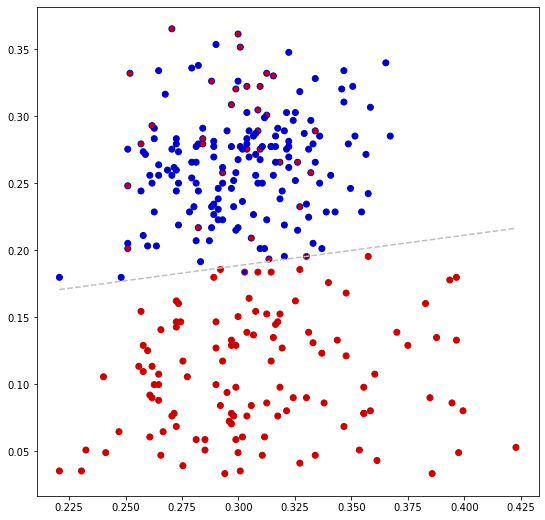

Accuracy: 0.9726027397260274
CPU times: user 3.09 s, sys: 3.99 ms, total: 3.1 s
Wall time: 3.1 s


In [41]:
%%time
c = PerceptronBest(iterations=10000)
c.fit(X_train, y_train)
visualize(X_train, y_train, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [42]:
%%time
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = Perceptron(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6655428001800759
CPU times: user 31.2 s, sys: 8 ms, total: 31.2 s
Wall time: 31.2 s


In [43]:
%%time
accs = []
for y0, y1 in [(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]:
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=20000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

Mean accuracy: 0.6509717190339739
CPU times: user 3min 56s, sys: 32 ms, total: 3min 56s
Wall time: 3min 56s
